In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load and preprocess data
df = pd.read_csv("feature_target.dat", sep=" ", )
df = df.dropna(axis=1)
df_clean = df.drop(columns=['Unnamed: 0', 'formula'])  # Drop non-numeric columns

# Define features and target
X = df_clean.drop(columns=["diff_coeff_mul_thousand"])
y = df_clean["diff_coeff_mul_thousand"]




In [76]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=62)

# Bootstrapping parameters
n_bootstraps = 100
predictions_train = []
predictions_test = []
bootstrap_indices = []

# Train multiple models on bootstrap samples
for i in range(n_bootstraps):
    # Generate bootstrap sample
    indices = np.random.choice(len(X_train), len(X_train), replace=True)
    X_train_sample = X_train.iloc[indices]
    y_train_sample = y_train.iloc[indices]
    
    # Store indices
    bootstrap_indices.append(indices)
    
    # Train XGBoost model
    model = xgb.XGBRegressor(n_estimators=100, max_depth=4, n_jobs=6,
                                reg_alpha=0.8, learning_rate=0.1,
                                 eval_metric="rmse", random_state=62)
    model.fit(X_train_sample, y_train_sample)
    
    # Make predictions on the training set and test set
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    predictions_train.append(y_train_pred)
    predictions_test.append(y_test_pred)

# Convert predictions to NumPy arrays
predictions_train = np.array(predictions_train)
predictions_test = np.array(predictions_test)

# Calculate mean and standard deviation of predictions for training and test sets
mean_predictions_train = np.mean(predictions_train, axis=0)
std_dev_predictions_train = np.std(predictions_train, axis=0)
mean_predictions_test = np.mean(predictions_test, axis=0)
std_dev_predictions_test = np.std(predictions_test, axis=0)

# Get the indices of the training and test set samples
train_indices = X_train.index
test_indices = X_test.index

# Create new dataframes to store the results
results_df_train = df.loc[train_indices].copy()
results_df_train['mean_prediction'] = mean_predictions_train
results_df_train['std_dev_prediction'] = std_dev_predictions_train

results_df_test = df.loc[test_indices].copy()
results_df_test['mean_prediction'] = mean_predictions_test
results_df_test['std_dev_prediction'] = std_dev_predictions_test

# Sort the dataframes by the standard deviation to identify formulas with higher error bars
results_df_train_sorted = results_df_train.sort_values(by='std_dev_prediction', ascending=False)
results_df_test_sorted = results_df_test.sort_values(by='std_dev_prediction', ascending=False)

# Display the top results with highest error bars for both training and test sets
top_results_train = results_df_train_sorted.head()
top_results_test = results_df_test_sorted.head()

# Plot results with error bars for the test set
# plt.figure(figsize=(10, 6))
# plt.errorbar(range(len(mean_predictions_test)), mean_predictions_test, yerr=std_dev_predictions_test, fmt='o', ecolor='r', capsize=5)
# plt.xlabel('Sample index')
# plt.ylabel('Prediction')
# plt.title('XGBoost Predictions with Error Bars (Test Set)')
# plt.show()
# Plot results with error bars for the training set using Plotly
fig_train = go.Figure()

fig_train.add_trace(go.Scatter(
    x=list(range(len(mean_predictions_train))),
    y=mean_predictions_train,
    error_y=dict(type='data', array=std_dev_predictions_train, visible=True),
    mode='markers',
    marker=dict(color='blue'),
    text=results_df_train['formula'],  # Add formula names for hover information
    hoverinfo='text+y'
))

fig_train.update_layout(
    title='XGBoost Predictions with Error Bars (Training Set)',
    xaxis_title='Sample index',
    yaxis_title='Prediction'
)

fig_train.show()



In [77]:
import plotly.graph_objects as go

# Create a parity plot using Plotly
fig_parity = go.Figure()

fig_parity.add_trace(go.Scatter(
    x=results_df_train_sorted['diff_coeff_mul_thousand'],
    y=results_df_train_sorted['mean_prediction'],
    error_y=dict(type='data', array=results_df_train_sorted['std_dev_prediction'], visible=True),
    mode='markers',
    marker=dict(color='blue'),
    text=results_df_train_sorted['formula'],  # Add formula names for hover information
    hoverinfo='text+x+y'
))

# Add a line y=x for reference
fig_parity.add_trace(go.Scatter(
    x=[min(results_df_train_sorted['diff_coeff_mul_thousand']), max(results_df_train_sorted['diff_coeff_mul_thousand'])],
    y=[min(results_df_train_sorted['diff_coeff_mul_thousand']), max(results_df_train_sorted['diff_coeff_mul_thousand'])],
    mode='lines',
    line=dict(color='red', dash='dash'),
    showlegend=False
))

fig_parity.update_layout(
    font=dict(family="Arial", size=36, color="black"),
    title=dict(text='XGBoost Training Set', x=0.5, y=0.9),
    xaxis_title='DFT D<sub>Li</sub> (x10<sup>-3</sup> cm<sup>2</sup>/s)',
    yaxis_title='RF D<sub>Li</sub> (x10<sup>-3</sup> cm<sup>2</sup>/s)',
    showlegend=False,
    width=640,  # Set figure width
    height=600 ,  # Set figure height
    paper_bgcolor='rgba(0,0,0,0)',  # Set paper (figure) background to transparent
    plot_bgcolor='rgba(0,0,0,0)',  # Set plot background to transparent    
    xaxis=dict(gridcolor='gray'),  # Set x-axis grid lines to gray
    yaxis=dict(gridcolor='gray')   # Set y-axis grid lines to gray    
)

fig_parity.write_html("parity_plot_XGBoost.html")
fig_parity.write_image("parity_plot_XGBoost.pdf")
fig_parity.show()


In [78]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming you have your X and y datasets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost model
xgb = XGBRegressor(n_estimators=200, max_depth=4, n_jobs=6, reg_alpha=0.8,
                         learning_rate=0.1, random_state=62, eval_metric="rmse")

# Train the model with evaluation sets
xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

# Get evaluation results
results = xgb.evals_result()

# Prepare data for Plotly
epochs = len(results['validation_0']['rmse'])
x_axis = list(range(0, epochs))

# Create traces
trace1 = go.Scatter(
    x=x_axis, 
    y=results['validation_0']['rmse'], 
    mode='lines', 
    name='Train'
)
trace2 = go.Scatter(
    x=x_axis, 
    y=results['validation_1']['rmse'], 
    mode='lines', 
    name='Test'
)

# Create layout
layout = go.Layout(
    title='XGBoost Training and Testing Loss',
    xaxis=dict(title='Epochs'),
    yaxis=dict(title='RMSE')
)

# Create figure and add traces
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.add_shape(type="line",
              x0=0, y0=0, x1=1, y1=0,
              line=dict(color="black", width=2),
              xref="paper", yref="y")

fig.update_layout(
    font=dict(family="Arial", size=36, color="black"),
    title=dict(text='XGBoost Loss Curves', x=0.5, y=0.9),
    xaxis_title='Epochs',
    yaxis_title='RMSE',
    showlegend=True,
    width=800,  # Set figure width
    height=600 ,  # Set figure height
    paper_bgcolor='rgba(0,0,0,0)',  # Set paper (figure) background to transparent
    plot_bgcolor='rgba(0,0,0,0)',  # Set plot background to transparent    
    xaxis=dict(gridcolor='gray'),  # Set x-axis grid lines to gray
    yaxis=dict(gridcolor='gray')   # Set y-axis grid lines to gray    
)

fig.write_html("XGBoost_RMSE_vs_Epochs.html")
fig.write_image("XGBoost_RMSE_vs_Epochs.pdf")
# Show figure
fig.show()


[0]	validation_0-rmse:0.49143	validation_1-rmse:0.51656
[1]	validation_0-rmse:0.45196	validation_1-rmse:0.47480


[2]	validation_0-rmse:0.41671	validation_1-rmse:0.43757
[3]	validation_0-rmse:0.38536	validation_1-rmse:0.40543
[4]	validation_0-rmse:0.35767	validation_1-rmse:0.37544
[5]	validation_0-rmse:0.33195	validation_1-rmse:0.34951
[6]	validation_0-rmse:0.30825	validation_1-rmse:0.32694
[7]	validation_0-rmse:0.28709	validation_1-rmse:0.30465
[8]	validation_0-rmse:0.26807	validation_1-rmse:0.28758
[9]	validation_0-rmse:0.25204	validation_1-rmse:0.27099
[10]	validation_0-rmse:0.23709	validation_1-rmse:0.25649
[11]	validation_0-rmse:0.22342	validation_1-rmse:0.24242
[12]	validation_0-rmse:0.21132	validation_1-rmse:0.23066
[13]	validation_0-rmse:0.19991	validation_1-rmse:0.21911
[14]	validation_0-rmse:0.18920	validation_1-rmse:0.20925
[15]	validation_0-rmse:0.17986	validation_1-rmse:0.20031
[16]	validation_0-rmse:0.17206	validation_1-rmse:0.19252
[17]	validation_0-rmse:0.16398	validation_1-rmse:0.18636
[18]	validation_0-rmse:0.15679	validation_1-rmse:0.17990
[19]	validation_0-rmse:0.15054	validati

In [79]:

import plotly.graph_objects as go

# Create a parity plot using Plotly
fig_parity = go.Figure()

fig_parity.add_trace(go.Scatter(
    x=results_df_test_sorted['diff_coeff_mul_thousand'],
    y=results_df_test_sorted['mean_prediction'],
    error_y=dict(type='data', array=results_df_test_sorted['std_dev_prediction'], visible=True),
    mode='markers',
    marker=dict(color='blue'),
    text=results_df_test_sorted['formula'],  # Add formula names for hover information
    hoverinfo='text+x+y'
))

# Add a line y=x for reference
fig_parity.add_trace(go.Scatter(
    x=[min(results_df_test_sorted['diff_coeff_mul_thousand']), max(results_df_test_sorted['diff_coeff_mul_thousand'])],
    y=[min(results_df_test_sorted['diff_coeff_mul_thousand']), max(results_df_test_sorted['diff_coeff_mul_thousand'])],
    mode='lines',
    line=dict(color='red', dash='dash'),
    showlegend=False
))

fig_parity.update_layout(
    font=dict(family="Arial", size=36, color="black"),
    title=dict(text='XGBoost Test Set', x=0.5, y=0.9),
    xaxis_title='DFT D<sub>Li</sub> (x10<sup>-3</sup> cm<sup>2</sup>/s)',
    yaxis_title='XGBoost D<sub>Li</sub> (x10<sup>-3</sup> cm<sup>2</sup>/s)',
    showlegend=False,
    width=640,  # Set figure width
    height=600 ,  # Set figure height
    paper_bgcolor='rgba(0,0,0,0)',  # Set paper (figure) background to transparent
    plot_bgcolor='rgba(0,0,0,0)',  # Set plot background to transparent    
    xaxis=dict(gridcolor='gray'),  # Set x-axis grid lines to gray
    yaxis=dict(gridcolor='gray')   # Set y-axis grid lines to gray    
)

fig_parity.write_html("parity_plot_XGBoost_test.html")
fig_parity.write_image("parity_plot_XGBoost_test.pdf")
fig_parity.show()


In [112]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np

# Assuming X_train, X_test, y_train, y_test are already defined

# Step 1: Train the model
model = xgb.XGBRegressor(n_estimators=100, max_depth=4, n_jobs=6, reg_alpha=0.8,
                         learning_rate=0.1, random_state=62)

# Train the model
model.fit(X_train, y_train)

# Step 2: Predict on the training data
mean_prediction_train = model.predict(X_train)

# Step 3: Calculate MAE, R2, and RMSE for the training data
mae_train = mean_absolute_error(y_train, mean_prediction_train)
r2_train = r2_score(y_train, mean_prediction_train)
rmse_train = np.sqrt(mean_squared_error(y_train, mean_prediction_train))

print("Training Data - MAE:", mae_train)
print("Training Data - R2:", r2_train)
print("Training Data - RMSE:", rmse_train)

# Step 4: Predict on the test data
mean_prediction_test = model.predict(X_test)

# Step 5: Calculate MAE, R2, and RMSE for the test data
mae_test = mean_absolute_error(y_test, mean_prediction_test)
r2_test = r2_score(y_test, mean_prediction_test)
rmse_test = np.sqrt(mean_squared_error(y_test, mean_prediction_test))

print("Test Data - MAE:", mae_test)
print("Test Data - R2:", r2_test)
print("Test Data - RMSE:", rmse_test)

Training Data - MAE: 0.037410745862727746
Training Data - R2: 0.9892707073214386
Training Data - RMSE: 0.055501733452002974
Test Data - MAE: 0.07002715815114295
Test Data - R2: 0.9707891714467861
Test Data - RMSE: 0.09594836612301258


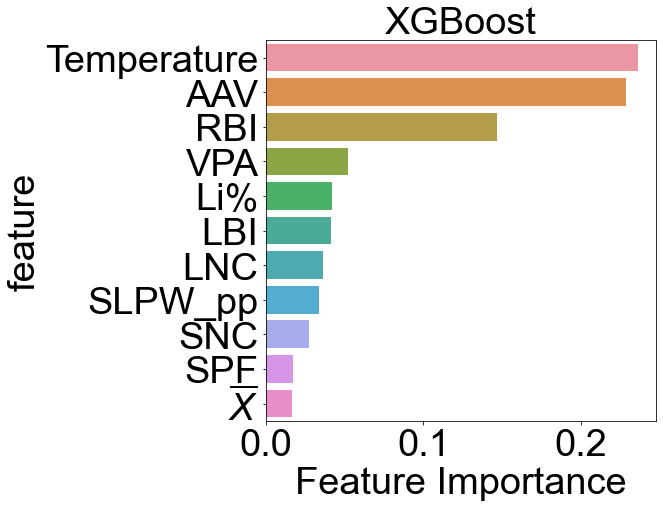

In [117]:

from matplotlib import colors as mcolors
import seaborn as sns
import pandas
import matplotlib
font_size = 38
matplotlib.rcParams['font.size'] = font_size
matplotlib.rcParams['axes.titlesize'] = font_size
matplotlib.rcParams['xtick.labelsize'] = font_size  # Set x-tick label size
matplotlib.rcParams['ytick.labelsize'] = font_size  # Set x-tick label size
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

model = xgb.XGBRegressor(n_estimators=100, max_depth=4, n_jobs=6, reg_alpha=0.8,
                         learning_rate=0.1, random_state=62)

# Train the model
model.fit(X_train, y_train)
feature_importances_rf = pandas.DataFrame({"feature": X_train.columns, "importance": model.feature_importances_}).sort_values(by="importance", ascending=False)
fig, ax = plt.subplots(figsize=(7,7))

# ax = sns.barplot(feature_importances_rf[0:11], x="importance", y="feature", ax=ax,)
ax = sns.barplot(data=feature_importances_rf[0:11], x="importance", y="feature", ax=ax)
plot_colors = [rect.get_facecolor() for rect in ax.patches]
plot_colors_hex = [mcolors.to_hex(rgba) for rgba in plot_colors]

labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = 'Temperature'
labels[10] = r'$\overline{X}$'
labels[4] = 'Li%'
# labels[12] = r'E$_{coh}^{Li}$'
# labels[14] = r'E$_{coh}$'

ax.set_yticklabels(labels)

# plt.yticks(ax.get_yticks(), labels, )

# fig = ax.get_figure()
plt.title("XGBoost")
plt.xlabel("Feature Importance")
fig.savefig('XGBoost_feature_importance.pdf',  bbox_inches='tight')
# plt.show()


In [86]:
feature_importances_rf.head(11)

,feature,importance
0,temperature,0.320180
6,RBI,0.242068
1,AAV,0.113788
40,avg_X_with_Li,0.049747
35,atomic_radius_avg,0.043115
22,Li_percentage,0.039896
21,SLPE,0.027607
12,LNC,0.025487
2,LBI,0.025219
17,PF,0.015444


In [106]:
feature_importances_rf.feature

0                      temperature
6                              RBI
1                              AAV
40                   avg_X_with_Li
35               atomic_radius_avg
22                   Li_percentage
21                            SLPE
12                             LNC
2                              LBI
17                              PF
5                              ENS
9                              VPA
42           avg_diff_of_X_Li_rest
27                avg_Ecoh_with_Li
18                             SPF
32                GR5_M_without_Li
10                            LASD
28               avg_Echo_wiout_Li
31                   GR5_M_with_Li
15                             SNC
29                   BR5_M_with_Li
25                   avg_G_with_Li
14                             LLB
13                            SDLC
34                ER2_m_without_Li
11                            LLSD
39                  avg_m_wiout_Li
37         ratio_r_without_Li_with
33                  

In [111]:
import shap


import numpy as np
import pandas as pd
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load and preprocess data
df = pd.read_csv("feature_target.dat", sep=" ", )
df_clean = df.drop(columns=['Unnamed: 0', 'formula'])  # Adjust columns as needed

# Define features and target
X = df_clean.drop(columns=["diff_coeff_mul_thousand"])
y = df_clean["diff_coeff_mul_thousand"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=62)

# Rename features in the X_test DataFrame
feature_renames = {
    'Li_percentage': 'Li%',
    'temperature': 'Temperature',   
    # 'avg_X_with_Li': r'$\overline{X}$',
    # 'avg_Echo_wiout_Li': r"$\overline{E_{coh}^{Li}}$ ",
    # 'avg_Echo_with_Li':r'$\overline{E_{coh}}$',
    # 'BR5_M_with_Li': '$\sqrt{\frac{E_{coh}\cdot\Bar{R}^2}{\Bar{m}}}$',
    # 'SLPW_PP':r'SLPW\_pp',
    # Add more renames as needed
    # 'original_feature_name': 'new_feature_name',
}

X_test_renamed = X_test.rename(columns=feature_renames)

# Define the model
model = xgb.XGBRegressor(n_estimators=100, max_depth=4, n_jobs=6, reg_alpha=0.8,
                         learning_rate=0.1, random_state=62)

# Train the model
model.fit(X_train, y_train)

# Calculate SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_test_renamed)

shap_importance = np.abs(shap_values.values).mean(axis=0)
top_11_indices = np.argsort(shap_importance)[-11:]

# Subset the SHAP values and feature data to the top 11 features
shap_values_top_11 = shap_values[:, top_11_indices]
X_test_renamed_top_11 = X_test_renamed.iloc[:, top_11_indices]

# Generate and save SHAP summary plot for the top 11 features
shap.summary_plot(shap_values_top_11, X_test_renamed_top_11, show=False)
plt.savefig("XGBoost_shap_summary_plot_top_11.pdf", bbox_inches='tight', dpi=300)
plt.close()  # Close the plot to free memory

# fig, ax = plt.subplots(figsize=(7,7))

# # Generate SHAP summary plot with renamed features
# plt = shap.summary_plot(shap_values, X_test_renamed, show=False)
# fig.savefig("XGBoost_shap_summary_plot.pdf", bbox_inches='tight')





In [97]:
pwd

'/Users/huizheng/repos/glassy/src/glassy/analysis_plots'

In [84]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error
import plotly.graph_objects as go
from math import sqrt


# Load and preprocess data
df = pd.read_csv("feature_target.dat", sep=" ", )
df_clean = df.drop(columns=['Unnamed: 0', 'formula'])  # Adjust columns as needed

# Define features and target
X = df_clean.drop(columns=["diff_coeff_mul_thousand"])
y = df_clean["diff_coeff_mul_thousand"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=62)

# Define cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=62)

# Define the model
model = xgb.XGBRegressor(n_estimators=100, max_depth=4, n_jobs=6, reg_alpha=0.8,
                         learning_rate=0.1, random_state=62)

# Define scoring metric
# Define custom RMSE scoring function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = make_scorer(rmse, greater_is_better=False)


# Perform cross-validation
cv_results = cross_val_score(model, X_train, y_train, cv=kf, scoring=scoring)
cv_mean = np.mean(cv_results)
cv_std = np.std(cv_results)

print(f"Cross-Validation RMSE: {cv_mean:.3f} ± {cv_std:.3f}")

# Optionally, perform grid search for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [2, 4, 6],
}

grid_search = GridSearchCV(model, param_grid, cv=kf, scoring=scoring)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# Train the best model on the entire training set
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = best_model.predict(X_test)

# Calculate mean and standard deviation of predictions using bootstrapping
n_bootstraps = 100
predictions_test = []

for i in range(n_bootstraps):
    indices = np.random.choice(len(X_train), len(X_train), replace=True)
    X_train_sample = X_train.iloc[indices]
    y_train_sample = y_train.iloc[indices]
    
    model = xgb.XGBRegressor(n_estimators=100, 
     max_depth=4, n_jobs=6, reg_alpha=0.8, learning_rate=0.5,
    random_state=62)
    model.fit(X_train_sample, y_train_sample)
    
    y_test_pred = model.predict(X_test)
    predictions_test.append(y_test_pred)

predictions_test = np.array(predictions_test)
mean_predictions_test = np.mean(predictions_test, axis=0)
std_dev_predictions_test = np.std(predictions_test, axis=0)

# Get the indices of the test set samples
test_indices = X_test.index

# Create a new dataframe to store the results
results_df_test = df.loc[test_indices].copy()
results_df_test['mean_prediction'] = mean_predictions_test
results_df_test['std_dev_prediction'] = std_dev_predictions_test

# Sort the dataframe by the standard deviation to identify formulas with higher error bars
results_df_test_sorted = results_df_test.sort_values(by='std_dev_prediction', ascending=False)

# Display the top results with highest error bars for the test set
top_results_test = results_df_test_sorted.head()

# Parity plot for the test set using Plotly
fig_parity = go.Figure()

fig_parity.add_trace(go.Scatter(
    x=results_df_test['diff_coeff_mul_thousand'],
    y=results_df_test['mean_prediction'],
    error_y=dict(type='data', array=results_df_test['std_dev_prediction'], visible=True),
    mode='markers',
    marker=dict(color='blue'),
    text=results_df_test['formula'],  # Add formula names for hover information
    hoverinfo='text+x+y'
))

# Add a line y=x for reference
fig_parity.add_trace(go.Scatter(
    x=[min(results_df_test['diff_coeff_mul_thousand']), max(results_df_test['diff_coeff_mul_thousand'])],
    y=[min(results_df_test['diff_coeff_mul_thousand']), max(results_df_test['diff_coeff_mul_thousand'])],
    mode='lines',
    line=dict(color='red', dash='dash'),
    showlegend=False
))

fig_parity.update_layout(
    title='Parity Plot: Actual vs Predicted Diffusion Coefficients',
    xaxis_title='Actual Diffusion Coefficient (x1000)',
    yaxis_title='Predicted Diffusion Coefficient (x1000)'
)

fig_parity.show()

# Print a few results for inspection
# print("Top test results with highest error bars:")
# print(top_results_test)

# Optionally, save the results to CSV files
# results_df_test_sorted.to_csv('test_results_with_error_bars.csv', index=False)


Cross-Validation RMSE: -0.123 ± 0.020
Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150}


In [87]:
# Define the model
model = xgb.XGBRegressor(n_estimators=100, max_depth=4, n_jobs=6, reg_alpha=0.8,
                         learning_rate=0.1, random_state=62)

# Define scoring metric
# Define custom RMSE scoring function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = make_scorer(rmse, greater_is_better=False)


# Perform cross-validation
cv_results = cross_val_score(model, X_train, y_train, cv=kf, scoring=scoring)
cv_mean = np.mean(cv_results)
cv_std = np.std(cv_results)

print(f"Cross-Validation RMSE: {cv_mean:.3f} ± {cv_std:.3f}")


Cross-Validation RMSE: -0.123 ± 0.020
